In [1]:
import sys
Path = '/remote/tychodata/ftairli/work/Projects/GNN_SDP/Code/'
if Path not in sys.path:
    sys.path.append(Path)
    
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from Dataset import GraphDatasetContainer
from TrainingModule import IterateInBatches

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
Name = 'Model_1_2'
Model = torch.load(f'{Name}.pt')
Tracker = torch.load(f'{Name}_Tracker.pt')
print(Model.Description)


        Try to predict the SDP, 
        two parameters: Phi and Theta ->  Predict their Sin and Cos
        Using TAGConv, supposedly to check for topology
        Also added Self Loops, might help with the K-Hop Conv
        Also Will now cut the Edges based on time
        


In [3]:
print(f'Final Loss           : {Tracker.EpochLoss[-1]}')
print(f'Final Validation Loss: {Tracker.EpochValLoss[-1]}')

Final Loss           : 0.020937031760922303
Final Validation Loss: 0.020818091665759035


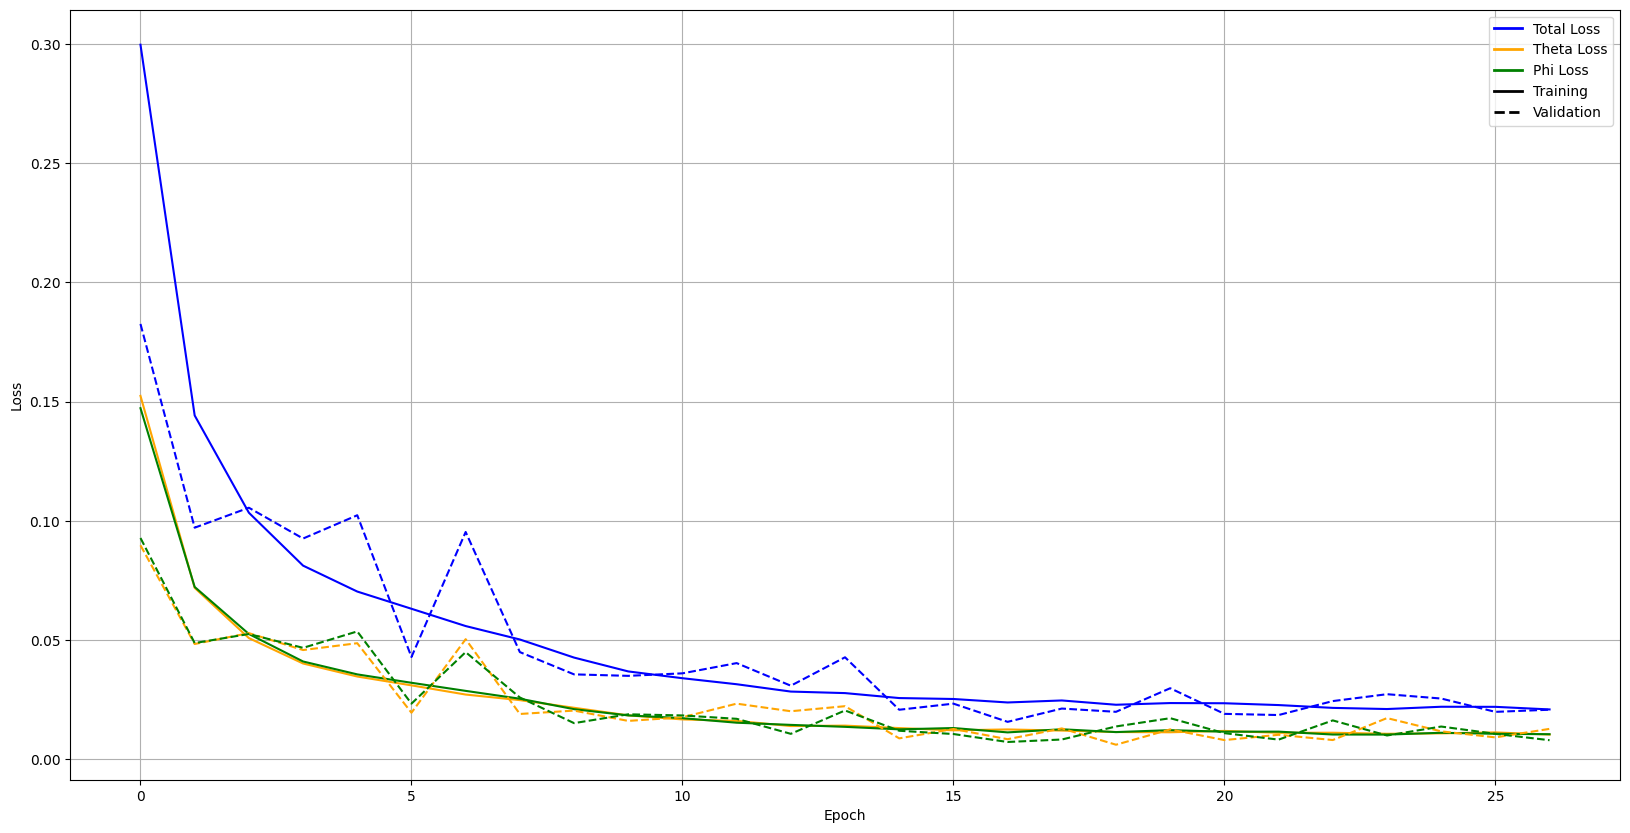

In [4]:
# plt.figure(figsize=(10, 10))
# plt.plot(Tracker.EpochLoss)
# plt.plot(Tracker.EpochValLoss)
# plt.yscale('log')

Total_loss = Tracker.EpochLoss
Theta_loss = Tracker.EpochLossTheta
Phi_loss   = Tracker.EpochLossPhi

Total_loss_val = Tracker.EpochValLoss
Theta_loss_val = Tracker.EpochValLossTheta
Phi_loss_val   = Tracker.EpochValLossPhi

Nepochs = len(Total_loss)
plt.figure(figsize=(20, 10))

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']

# Plot training loss
plt.plot(Total_loss, color=colors[0], label='Total Loss - Training')
plt.plot(Theta_loss, color=colors[1], label='Theta Loss - Training')
plt.plot(Phi_loss  , color=colors[2], label='Phi   Loss - Training')

# # Plot validation loss
plt.plot(Total_loss_val, color=colors[0], linestyle='dashed', label='Total Loss - Validation')
plt.plot(Theta_loss_val, color=colors[1], linestyle='dashed', label='Theta Loss - Validation')
plt.plot(Phi_loss_val  , color=colors[2], linestyle='dashed', label='Phi   Loss - Validation')

# Set up custom legend

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color='black'  , lw=2),
                Line2D([0], [0], color='black', linestyle='dashed', lw=2)]

plt.legend(custom_lines, ['Total Loss', 'Theta Loss', 'Phi Loss', 'Training', 'Validation'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.yscale('log')
plt.grid()
# plt.savefig(f'{Name}_Loss.png', dpi=300)


In [10]:
datapath = '/remote/tychodata/ftairli/work/Projects/GNN_SDP/Data/RawData/'
GraphDataset = GraphDatasetContainer(0)
GraphDataset.Load(datapath, 'Run010')





def GetTruths(GraphDataset):
    ALLSDPPhi = GraphDataset._otherData[:,18]
    ALLSDPTheta = GraphDataset._otherData[:,19]
    
    Truths = torch.cat((torch.cos(ALLSDPPhi).unsqueeze(1),torch.sin(ALLSDPPhi).unsqueeze(1),torch.cos(ALLSDPTheta).unsqueeze(1),torch.sin(ALLSDPTheta).unsqueeze(1)),dim=1)
    return Truths
def GetFeatures(GraphDataset):
    # Get Phi,Theta,Charge
    Features = GraphDataset._pixelData[:,[9,10,4]]
    # Normalise Features
    Features[:,0] = Features[:,0]/180
    Features[:,1] = Features[:,1]/90
    
    Features[:,2] = torch.log10(Features[:,2]+1)/7.25
    return Features


    

ProcessingDataset = GraphDataset.GetProcessingDataset(GetTruths, GetFeatures,GetFeatures,True,True,True)
ProcessingDataset.AssignIndices()
ProcessingDataset.RandomIter = False

In [11]:
def UnnormaliseOutputs(Outputs):
    SDPPhi   = torch.atan2(Outputs[:,1],Outputs[:,0])
    SDPTheta = torch.atan2(Outputs[:,3],Outputs[:,2])
    return torch.cat((SDPPhi.unsqueeze(1),SDPTheta.unsqueeze(1)),dim=1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


ProcessingDataset._StationFeatures = None
ProcessingDataset.State = 'Test'
ModelTruthSDP = torch.zeros(len(ProcessingDataset),4).to(device)
ModelPredSDP  = torch.zeros(len(ProcessingDataset),4).to(device)

Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchGraphBatching, BatchFeatures,BatchEdges,BatchEdgesWeights,BatchTruth in IterateInBatches(ProcessingDataset,1):
        BatchFeatures      = BatchFeatures     .to(device)
        BatchGraphBatching = BatchGraphBatching.to(device)
        BatchEdges         = BatchEdges        .to(device)
        BatchEdgesWeights  = BatchEdgesWeights .to(device)
        BatchTruth         = BatchTruth        .to(device)
        # print(f'EvI : {EvI} Edges.Shape : {BatchEdges.shape}')

        ModelTruthSDP[EvI,:] = BatchTruth
        ModelPredSDP[EvI,:]  = Model(BatchFeatures,BatchEdges,BatchEdgesWeights,BatchGraphBatching)
        EvI+=1


# drop Zero Values
Mask = (ModelTruthSDP[:,0]!=0) * (ModelPredSDP[:,0]!=0)
ModelTruthSDP = ModelTruthSDP[Mask]
ModelPredSDP  = ModelPredSDP [Mask]

ValueError: too many values to unpack (expected 5)

In [8]:

TruthSDP = UnnormaliseOutputs(ModelTruthSDP).to('cpu').numpy()
PredSDP  = UnnormaliseOutputs(ModelPredSDP ).to('cpu').numpy()

In [17]:
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean()

In [18]:
print(f'Mean Squared Error Phi   : {MeanSquaredError(TruthSDP[:,0],PredSDP[:,0])}')
print(f'Mean Squared Error Theta : {MeanSquaredError(TruthSDP[:,1],PredSDP[:,1])}')

print(f'Mean Absolute Error Phi   : {MeanAbsoluteError(TruthSDP[:,0],PredSDP[:,0])}')
print(f'Mean Absolute Error Theta : {MeanAbsoluteError(TruthSDP[:,1],PredSDP[:,1])}')

Mean Squared Error Phi   : 0.6615062952041626
Mean Squared Error Theta : 0.01838005520403385
Mean Absolute Error Phi   : 0.14348767697811127
Mean Absolute Error Theta : 0.07724229991436005


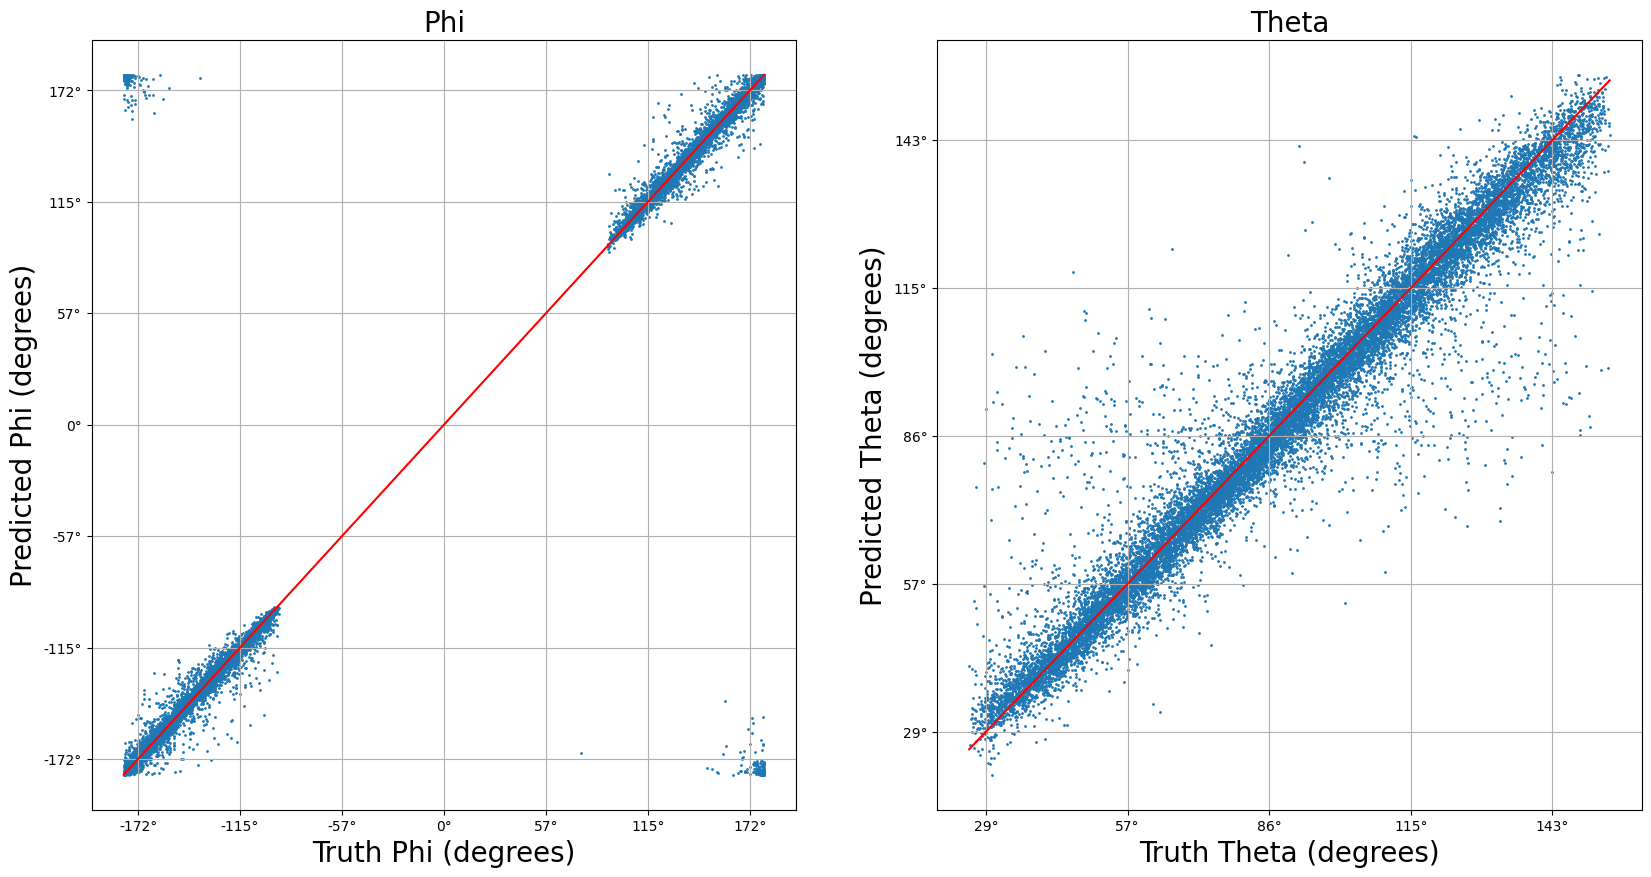

In [30]:
# Easy Scatter Plots of Truth vs Predicted
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(TruthSDP[:, 0], PredSDP[:, 0], s=1)
ax[0].plot([min(TruthSDP[:, 0]), max(TruthSDP[:, 0])], [min(TruthSDP[:, 0]), max(TruthSDP[:, 0])], 'r')
ax[0].set_xlabel('Truth Phi (degrees)',fontsize=20)
ax[0].set_ylabel('Predicted Phi (degrees)',fontsize=20)
ax[0].set_title('Phi',fontsize=20)

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
ax[0].grid()

# Scatter plot for the second subplot
ax[1].scatter(TruthSDP[:, 1], PredSDP[:, 1], s=1)
ax[1].plot([min(TruthSDP[:, 1]), max(TruthSDP[:, 1])], [min(TruthSDP[:, 1]), max(TruthSDP[:, 1])], 'r')
ax[1].set_xlabel('Truth Theta (degrees)',fontsize=20)
ax[1].set_ylabel('Predicted Theta (degrees)',fontsize=20)
ax[1].set_title('Theta',fontsize=20)

# Set x and y ticks for the second subplot
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[1].get_yticks()
ax[1].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
ax[1].grid()
# plt.savefig(f'../Results/')

plt.show()


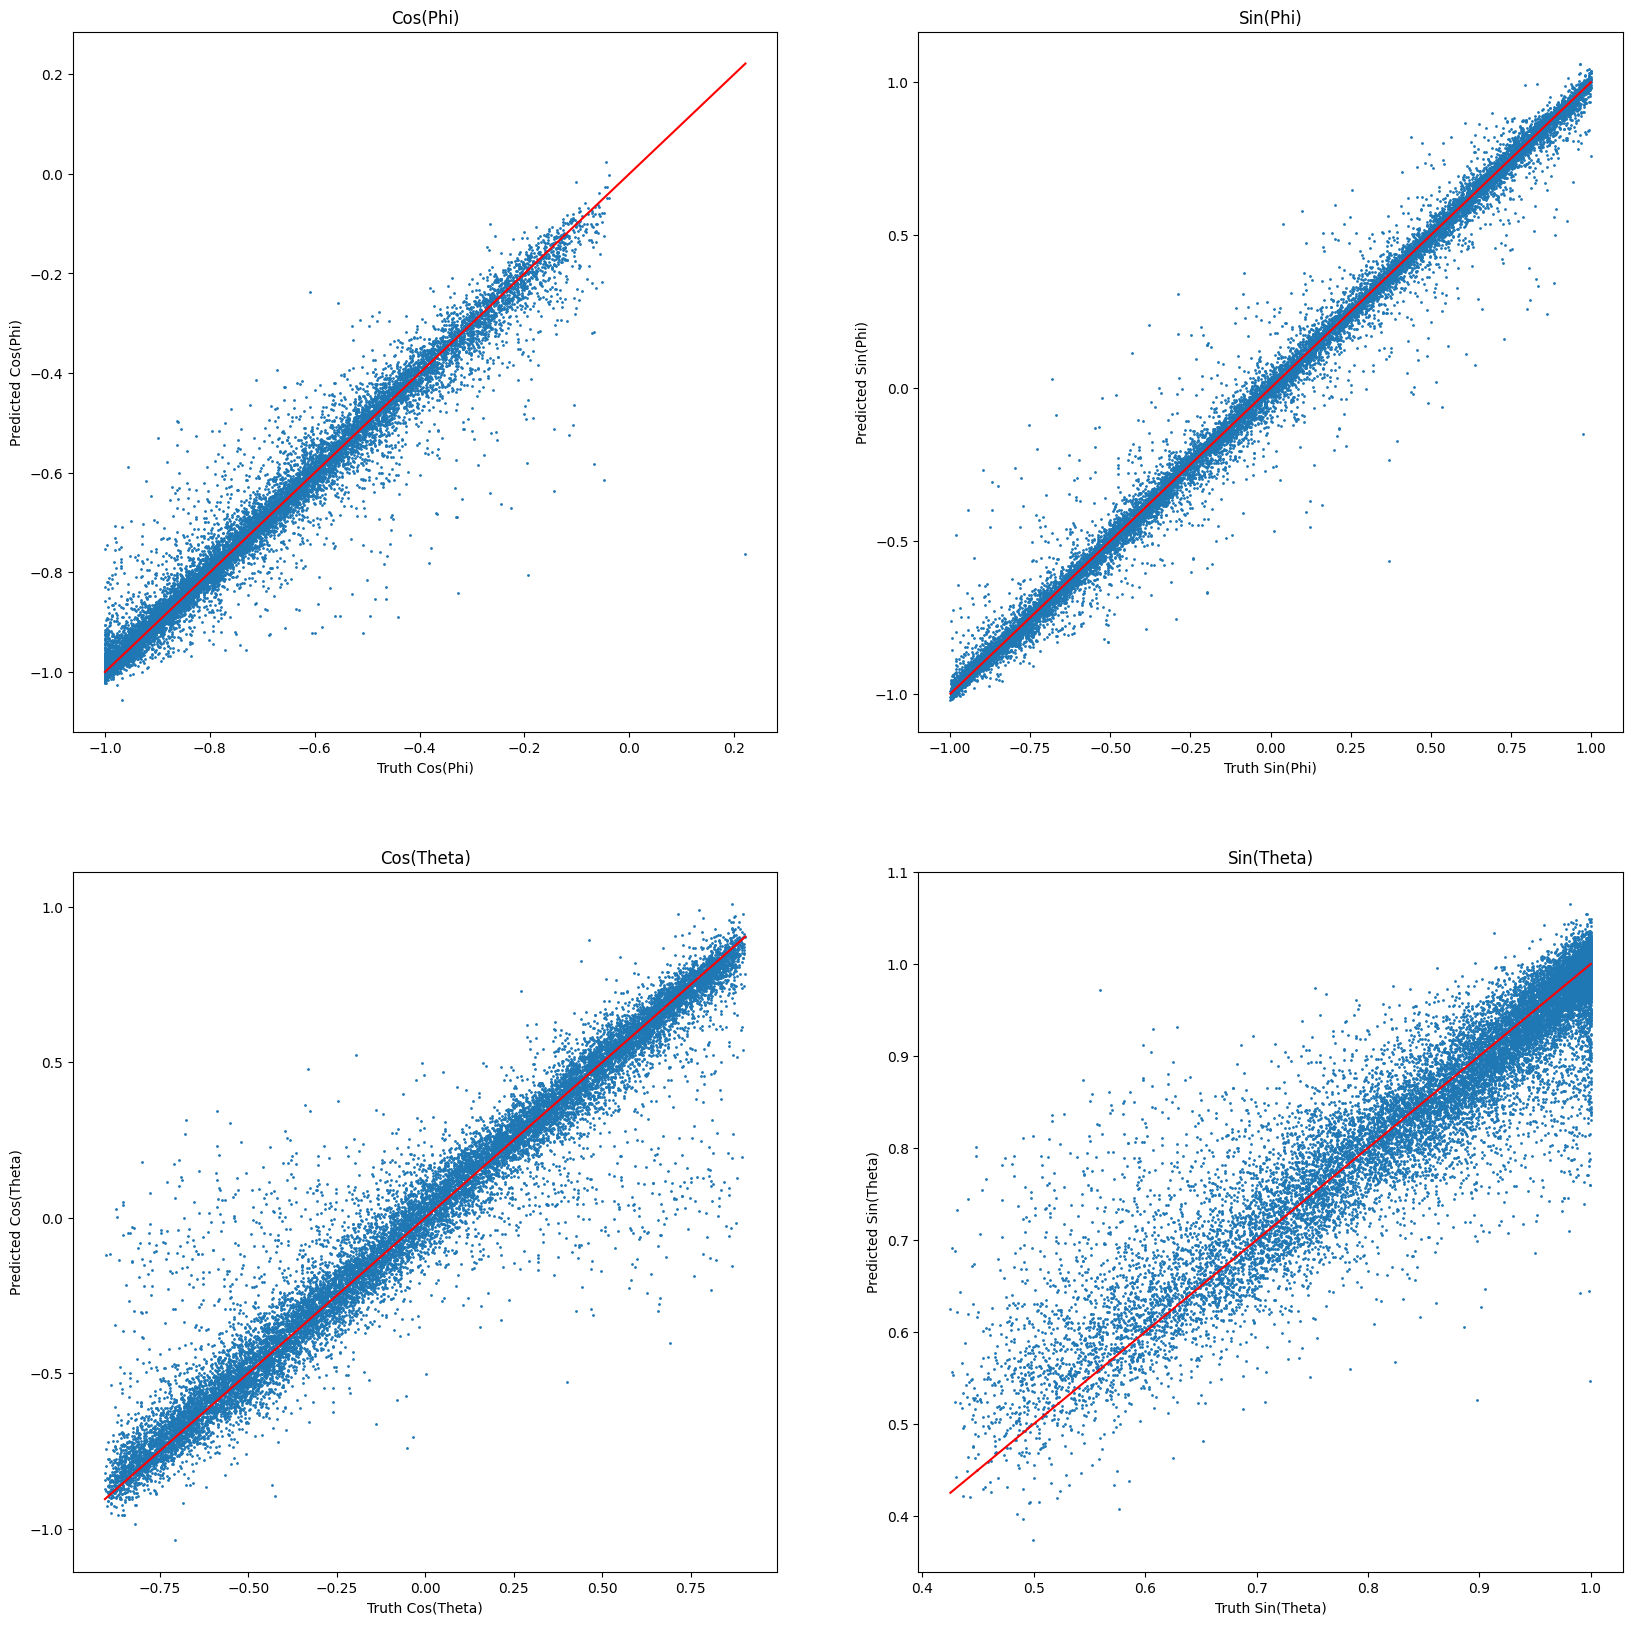

In [11]:
# Easy Scatter Plots of the Unnormed values
# Scatter the Unnormed values [cos(phi),sin(phi),cos(theta),sin(theta)]
if type(ModelPredSDP) == torch.Tensor:
    ModelPredSDP = ModelPredSDP.to('cpu').numpy()
    ModelTruthSDP = ModelTruthSDP.to('cpu').numpy()


fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# Scatter plot for the first subplot
ax[0,0].scatter(ModelTruthSDP[:, 0], ModelPredSDP[:, 0], s=1)
ax[0,0].plot([min(ModelTruthSDP[:, 0]), max(ModelTruthSDP[:, 0])], [min(ModelTruthSDP[:, 0]), max(ModelTruthSDP[:, 0])], 'r')
ax[0,0].set_xlabel('Truth Cos(Phi)')
ax[0,0].set_ylabel('Predicted Cos(Phi)')
ax[0,0].set_title('Cos(Phi)')


# Scatter plot for the second subplot
ax[0,1].scatter(ModelTruthSDP[:, 1], ModelPredSDP[:, 1], s=1)
ax[0,1].plot([min(ModelTruthSDP[:, 1]), max(ModelTruthSDP[:, 1])], [min(ModelTruthSDP[:, 1]), max(ModelTruthSDP[:, 1])], 'r')
ax[0,1].set_xlabel('Truth Sin(Phi)')
ax[0,1].set_ylabel('Predicted Sin(Phi)')
ax[0,1].set_title('Sin(Phi)')

# Scatter plot for the third subplot
ax[1,0].scatter(ModelTruthSDP[:, 2], ModelPredSDP[:, 2], s=1)
ax[1,0].plot([min(ModelTruthSDP[:, 2]), max(ModelTruthSDP[:, 2])], [min(ModelTruthSDP[:, 2]), max(ModelTruthSDP[:, 2])], 'r')
ax[1,0].set_xlabel('Truth Cos(Theta)')
ax[1,0].set_ylabel('Predicted Cos(Theta)')
ax[1,0].set_title('Cos(Theta)')

# Scatter plot for the fourth subplot
ax[1,1].scatter(ModelTruthSDP[:, 3], ModelPredSDP[:, 3], s=1)
ax[1,1].plot([min(ModelTruthSDP[:, 3]), max(ModelTruthSDP[:, 3])], [min(ModelTruthSDP[:, 3]), max(ModelTruthSDP[:, 3])], 'r')
ax[1,1].set_xlabel('Truth Sin(Theta)')
ax[1,1].set_ylabel('Predicted Sin(Theta)')
ax[1,1].set_title('Sin(Theta)')

plt.show()


In [13]:
def UnTrigOutputs(Outputs):
    if type(Outputs) != torch.Tensor:
        Outputs = torch.tensor(Outputs)
    Outputs[:,0] = torch.acos(Outputs[:,0])
    Outputs[:,1] = torch.asin(Outputs[:,1])
    Outputs[:,2] = torch.acos(Outputs[:,2])
    Outputs[:,3] = torch.asin(Outputs[:,3])
    return Outputs

UnTrigTruths = UnTrigOutputs(ModelTruthSDP)
UnTrigPreds  = UnTrigOutputs(ModelPredSDP)

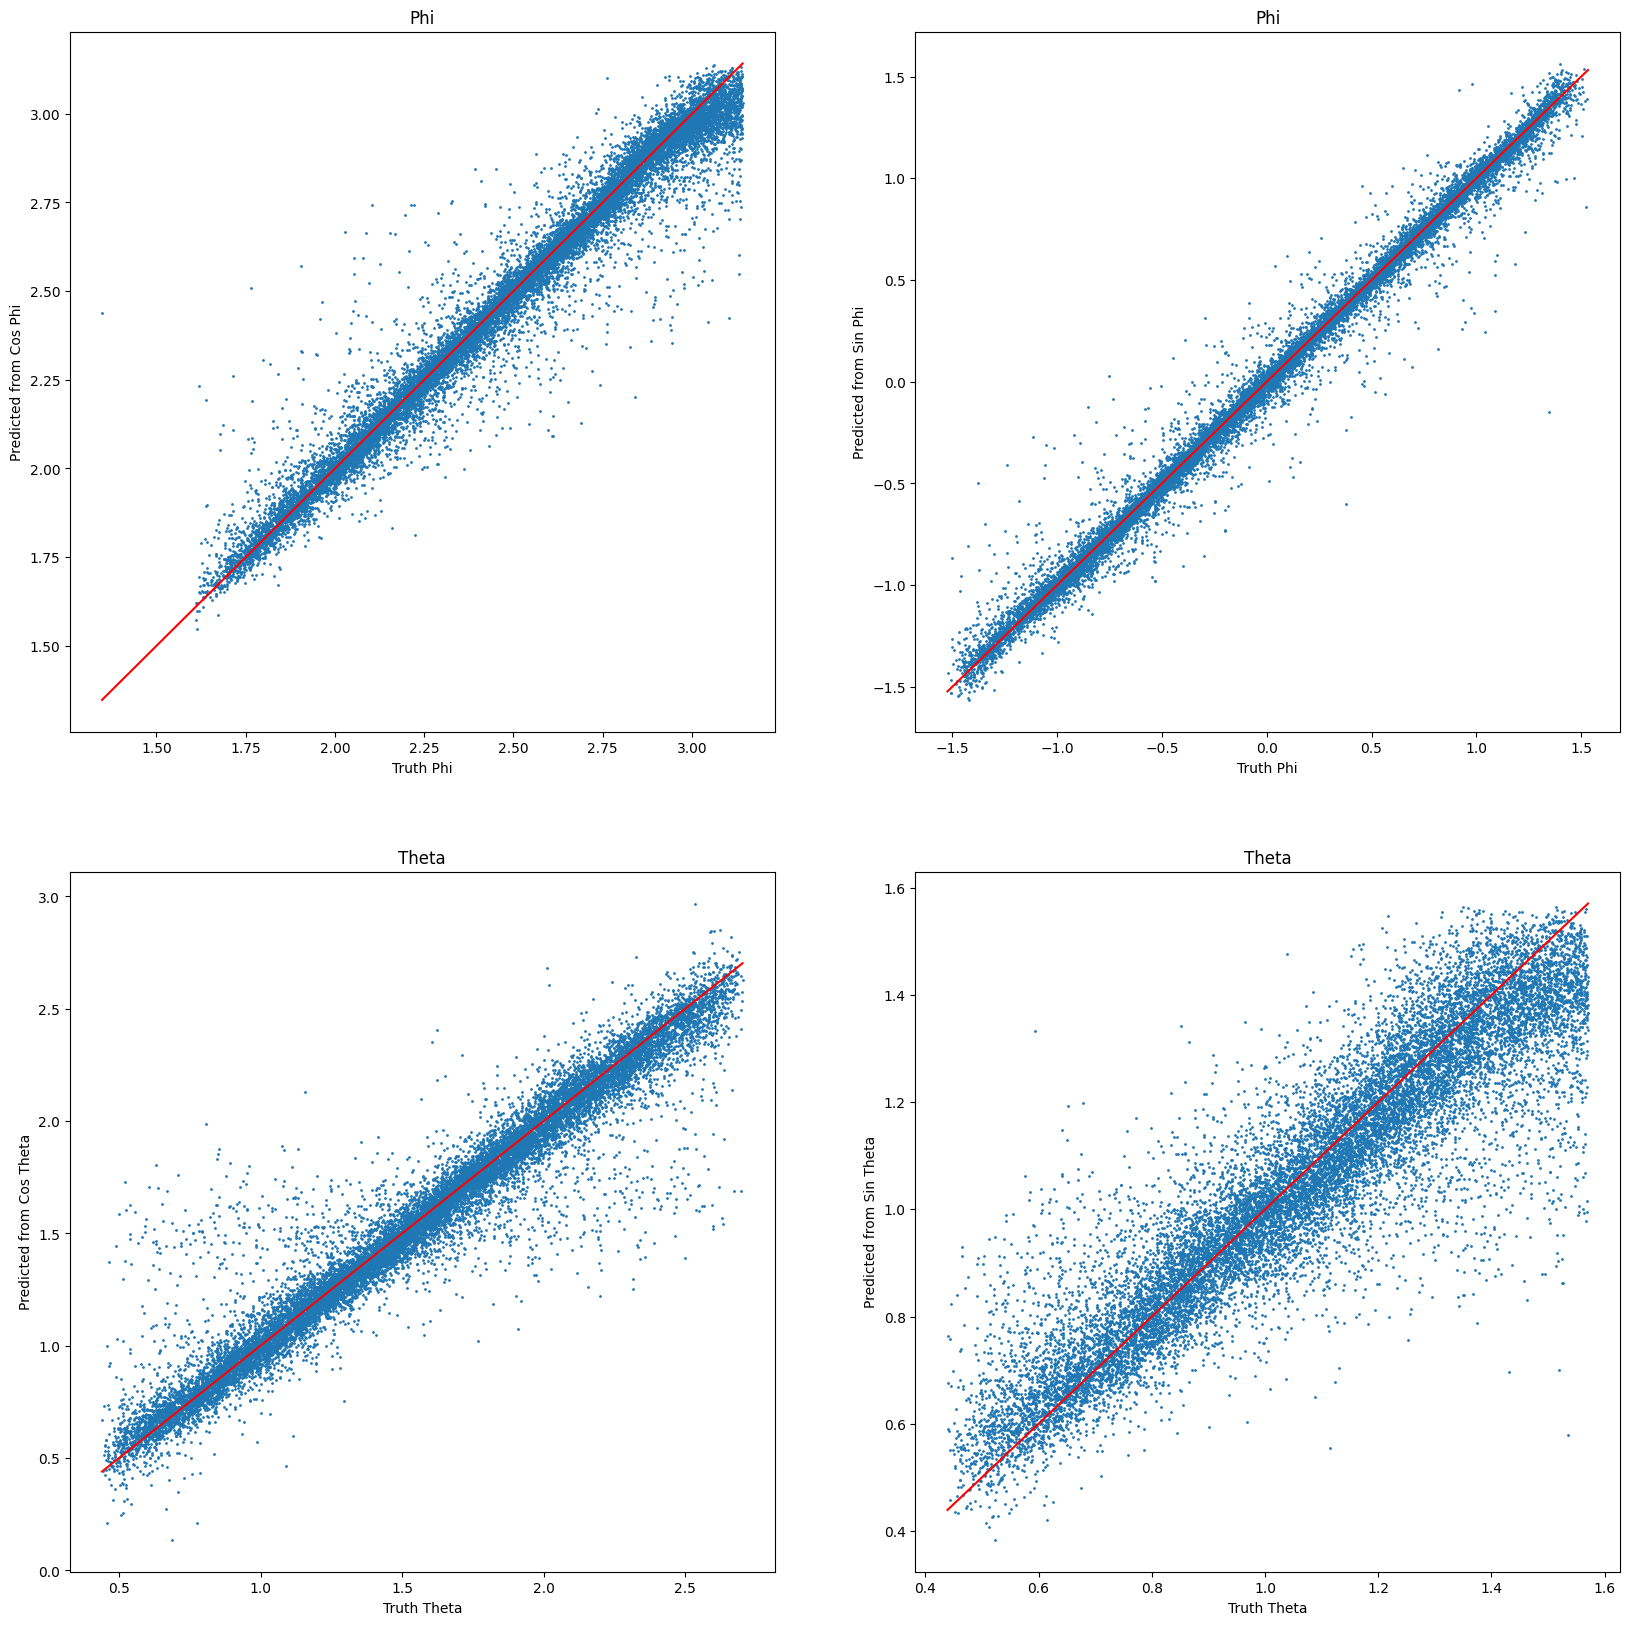

In [14]:
# Plot predictions from UnTrigOutputs
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# Scatter plot for the first subplot
ax[0,0].scatter(UnTrigTruths[:, 0], UnTrigPreds[:, 0], s=1)
ax[0,0].plot([min(UnTrigTruths[:, 0]), max(UnTrigTruths[:, 0])], [min(UnTrigTruths[:, 0]), max(UnTrigTruths[:, 0])], 'r')
ax[0,0].set_xlabel('Truth Phi')
ax[0,0].set_ylabel('Predicted from Cos Phi')
ax[0,0].set_title('Phi')


# Scatter plot for the second subplot
ax[0,1].scatter(UnTrigTruths[:, 1], UnTrigPreds[:, 1], s=1)
ax[0,1].plot([min(UnTrigTruths[:, 1]), max(UnTrigTruths[:, 1])], [min(UnTrigTruths[:, 1]), max(UnTrigTruths[:, 1])], 'r')
ax[0,1].set_xlabel('Truth Phi')
ax[0,1].set_ylabel('Predicted from Sin Phi')
ax[0,1].set_title('Phi')

# Scatter plot for the third subplot
ax[1,0].scatter(UnTrigTruths[:, 2], UnTrigPreds[:, 2], s=1)
ax[1,0].plot([min(UnTrigTruths[:, 2]), max(UnTrigTruths[:, 2])], [min(UnTrigTruths[:, 2]), max(UnTrigTruths[:, 2])], 'r')
ax[1,0].set_xlabel('Truth Theta')
ax[1,0].set_ylabel('Predicted from Cos Theta')
ax[1,0].set_title('Theta')

# Scatter plot for the fourth subplot
ax[1,1].scatter(UnTrigTruths[:, 3], UnTrigPreds[:, 3], s=1)
ax[1,1].plot([min(UnTrigTruths[:, 3]), max(UnTrigTruths[:, 3])], [min(UnTrigTruths[:, 3]), max(UnTrigTruths[:, 3])], 'r')
ax[1,1].set_xlabel('Truth Theta')
ax[1,1].set_ylabel('Predicted from Sin Theta')
ax[1,1].set_title('Theta')

plt.show()
